In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import time
%matplotlib inline

from sklearn import datasets
from sklearn.datasets import load_wine

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, accuracy_score

from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as SRP
from sklearn.ensemble import RandomForestClassifier as RF

In [3]:
# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
# load data
raw_data = load_wine()
X, y = raw_data.data, raw_data.target

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# normalize the input features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

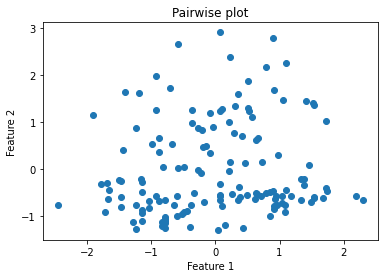

In [5]:
# pairwise plot two features
plt.scatter(X_train[:,0], X_train[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Pairwise plot')
plt.show() 

In [6]:
# check the correlations between features
df_x_train = pd.DataFrame(X_train)
corr = df_x_train.corr()
corr.shape

(13, 13)

In [7]:
# remove features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df_x_train.columns[columns]
selected_columns.shape

(13,)

### K-means

In [8]:
# function to tune k for k-means
def k_means_tuning(title, X, n_components):
    sse = []
    for i in n_components:
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    plt.plot(n_components, sse)
    plt.xlabel('Number of Components')
    plt.ylabel('SSE')
    plt.title(title)
    plt.grid()

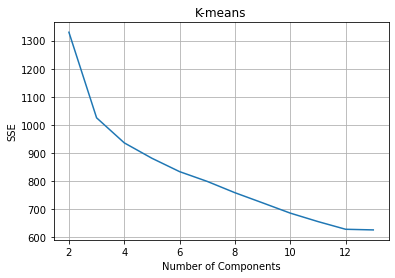

In [9]:
# parameter tuning k for k-means
n_components = range(2, 14)
k_means_tuning('K-means', X_train, n_components)

In [10]:
# function to evaluate k-means
def k_means_scoring(title, X, y, n_components):
    sc = []
    ami = []
    hs = []
    auc = []
    
    for i in n_components:
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
        kmeans.fit(X)
        sc_score = silhouette_score(X, kmeans.labels_)
        sc.append(sc_score)
        ami_score = adjusted_mutual_info_score(y, kmeans.labels_)
        ami.append(ami_score)
        hs_score = homogeneity_score(y, kmeans.labels_)
        hs.append(hs_score)
        auc_score = accuracy_score(y, kmeans.labels_)
        auc.append(auc_score)
        
    plt.plot(n_components, sc, label='silhouette score')
    plt.plot(n_components, ami, label='ami score')
    plt.plot(n_components, hs, label='homogeneity score')
    plt.plot(n_components, auc, label='accuracy score')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlabel('Number of Components')
    plt.title(title)
    plt.grid() 

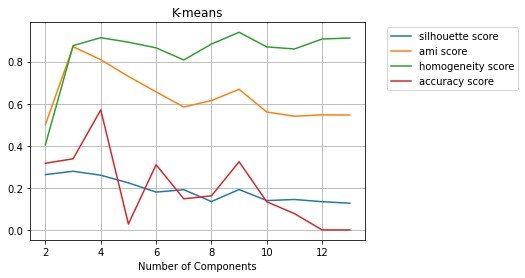

In [11]:
k_means_scoring('K-means', X_train, y_train, n_components)

In [12]:
# funtion to run k-means
def run_kmeans(X, n):
    kmeans = KMeans(n_clusters = n, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(X)
    y_pred = kmeans.predict(X)
    return y_pred

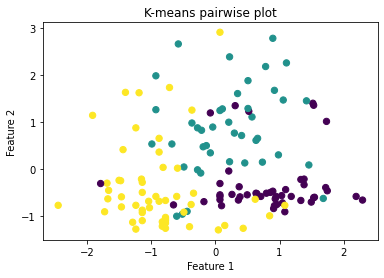

In [13]:
# k-means pairwise plot two features
y_pred = run_kmeans(X_train, 3)
def k_means_pairwise_plot(title, X, y_pred):
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=40, cmap='viridis')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
k_means_pairwise_plot('K-means pairwise plot', X_train, y_pred)

### Expectation Maximization

In [14]:
# function to tune number of components for em
def em_tuning(title, X, n_components):
    models = [GaussianMixture(n, covariance_type='tied', warm_start = True, random_state=42).fit(X)
          for n in n_components]

    plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('Number of Components')
    plt.title(title)
    plt.grid()

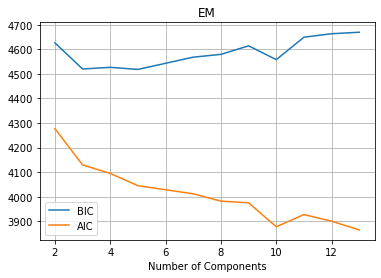

In [15]:
em_tuning('EM', X_train, n_components)

In [16]:
# function to evaluate EM
def em_scoring(title, X, y, k_range):
    sc = []
    ami = []
    hs = []
    auc = []
   
    for i in k_range:
        gmm = GaussianMixture(i, covariance_type='tied', warm_start = True, random_state=42)
        gmm.fit(X)
        gmm_labels = gmm.predict(X)
        sc_score = silhouette_score(X, gmm_labels)
        sc.append(sc_score)
        ami_score = adjusted_mutual_info_score(y, gmm_labels)
        ami.append(ami_score)
        hs_score = homogeneity_score(y, gmm_labels)
        hs.append(hs_score)
        auc_score = accuracy_score(y, gmm_labels)
        auc.append(auc_score)
        
    plt.plot(k_range, sc, label='silhouette score')
    plt.plot(k_range, ami, label='ami score')
    plt.plot(k_range, hs, label='homogeneity score')
    plt.plot(k_range, auc, label='accuracy score')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlabel('Number of Components')
    plt.title(title)
    plt.grid() 

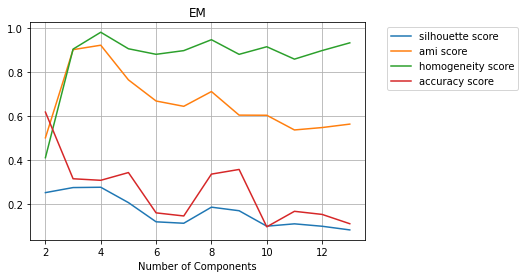

In [17]:
em_scoring('EM', X_train, y_train, n_components)

In [18]:
# funciton to run EM
def run_em(X, n):
    gmm = GaussianMixture(n, covariance_type='tied', warm_start = True, random_state=42)
    gmm.fit(X)
    gmm_labels = gmm.predict(X)
    return gmm_labels

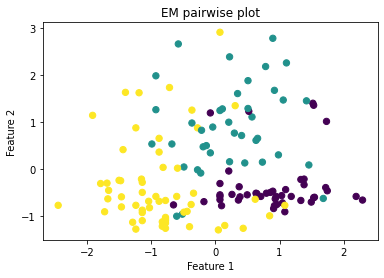

In [19]:
# EM pairwise plot two features
gmm_labels = run_em(X_train, 3)
def em_pairwise_plot(title, X, gmm_labels):
    plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, s=40, cmap='viridis')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
em_pairwise_plot('EM pairwise plot', X_train, gmm_labels)

### Dimensionality reduction

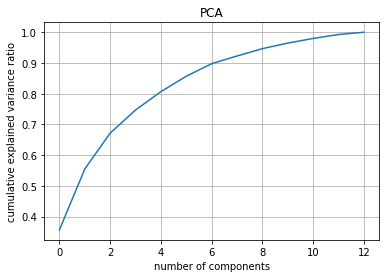

In [20]:
# PCA
pca = PCA(random_state=42).fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio')
plt.title('PCA')
plt.grid()

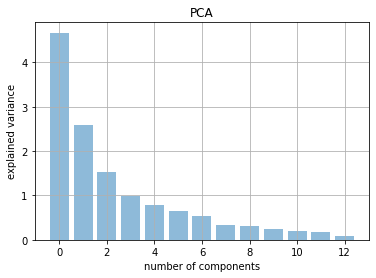

In [21]:
pca_variance = pca.explained_variance_
plt.bar(range(13), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title('PCA')
plt.grid()

In [22]:
# Choose the number of components that capture 90% of the variance
n_pca = 6

# Transform the data
pca1 = PCA(n_components=n_pca, random_state=42)
X_trans_pca = pca1.fit_transform(X_train)
X_test_pca = pca1.fit_transform(X_test)

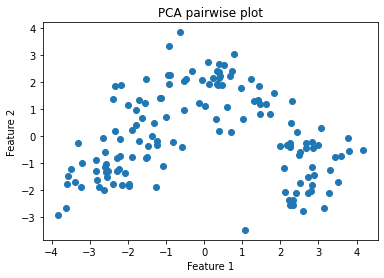

In [23]:
# pairwise plot two features
plt.scatter(X_trans_pca[:,0], X_trans_pca[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA pairwise plot')
plt.show()

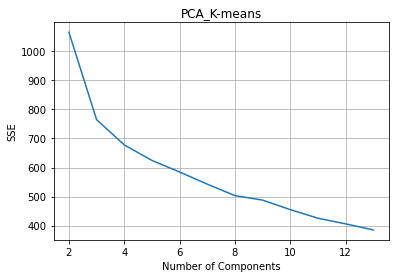

In [24]:
# PCA and k-means
k_means_tuning('PCA_K-means', X_trans_pca, n_components)

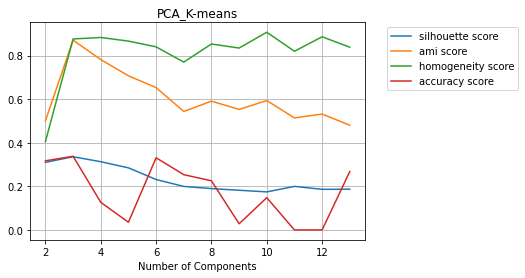

In [25]:
k_means_scoring('PCA_K-means', X_trans_pca, y_train, n_components)

In [26]:
# choose number of clusters that has the highest sc 
y_pred_pca = run_kmeans(X_trans_pca, 3)

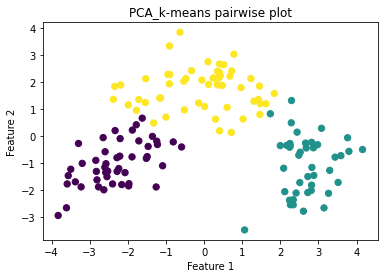

In [27]:
k_means_pairwise_plot('PCA_k-means pairwise plot', X_trans_pca, y_pred_pca)

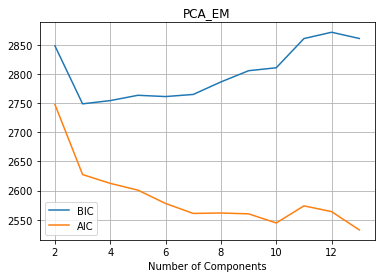

In [28]:
# PCA and EM
em_tuning('PCA_EM', X_trans_pca, n_components)

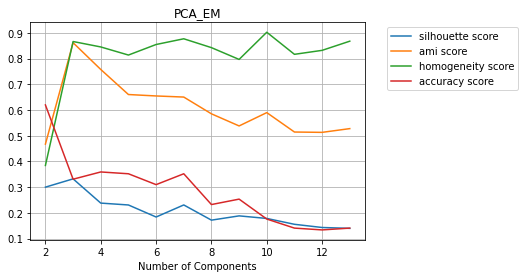

In [29]:
em_scoring('PCA_EM', X_trans_pca, y_train, n_components)

In [30]:
gmm_labels_pca = run_em(X_trans_pca, 3)

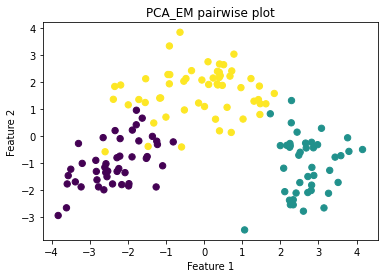

In [31]:
em_pairwise_plot('PCA_EM pairwise plot', X_trans_pca, gmm_labels_pca)

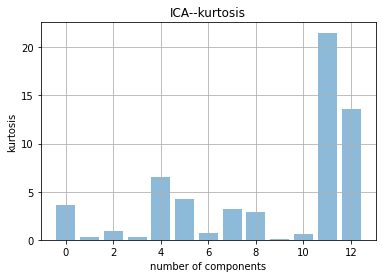

In [32]:
from scipy.stats import kurtosis
# Fit ICA
ica = ICA(whiten='arbitrary-variance', random_state=42)
X_ica = ica.fit_transform(X_train)  # Get the independent components

# Determine the number of components to use using the kurtosis criterion
kurtosis_scores = [np.abs(kurtosis(X_ica[:, i])) for i in range(X_ica.shape[1])]
# plt.plot(kurtosis_scores)
plt.bar(range(13), kurtosis_scores, alpha=0.5, align='center', label='kurtosis')
plt.xlabel('number of components')
plt.ylabel('kurtosis')
plt.title('ICA--kurtosis')
plt.grid()
plt.show()

In [33]:
n_ica = 11
# Transform the data
ica1 = ICA(n_components=n_ica, whiten='arbitrary-variance', random_state=42)
X_trans_ica = ica1.fit_transform(X_train)
X_test_ica = ica1.fit_transform(X_test)

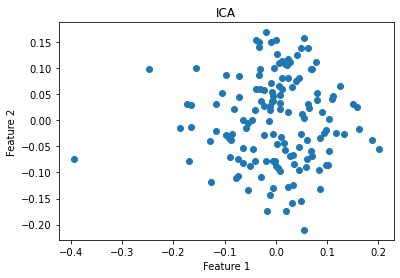

In [34]:
plt.scatter(X_trans_ica[:,0], X_trans_ica[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('ICA')
plt.show() 

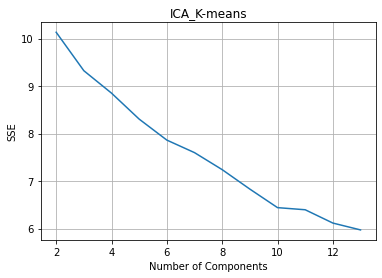

In [35]:
# ICA and k-means
k_means_tuning('ICA_K-means', X_trans_ica, n_components)

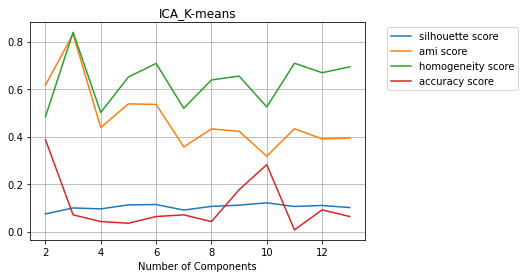

In [36]:
k_means_scoring('ICA_K-means', X_trans_ica, y_train, n_components)

In [37]:
# choose number of clusters that has the highest sc 
y_pred_ica = run_kmeans(X_trans_ica, 3)

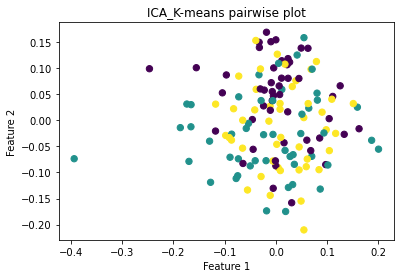

In [38]:
k_means_pairwise_plot('ICA_K-means pairwise plot', X_trans_ica, y_pred_ica)

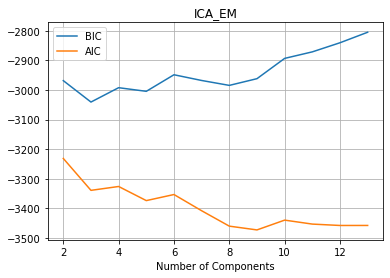

In [39]:
# ICA and EM
em_tuning('ICA_EM', X_trans_ica, n_components)

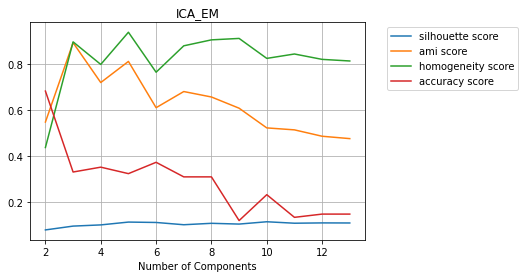

In [40]:
em_scoring('ICA_EM', X_trans_ica, y_train, n_components)

In [41]:
gmm_labels_ica = run_em(X_trans_ica, 3)

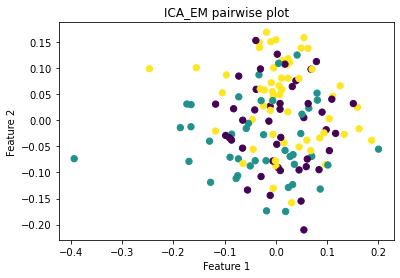

In [42]:
em_pairwise_plot('ICA_EM pairwise plot', X_trans_ica, gmm_labels_ica)

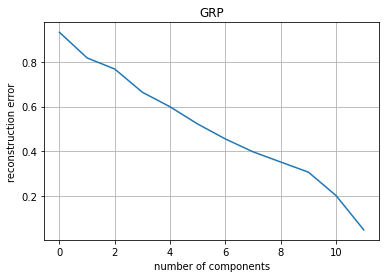

In [43]:
# GRP
reconstruction_error = []
for n in range(1, 13):
    grp = GRP(n_components=n, compute_inverse_components=True, random_state=42)
    X_grp = grp.fit_transform(X_train)
    X_grp_inverse = grp.inverse_transform(X_grp)
    reconstruction_error.append(((X_train - X_grp_inverse) ** 2).mean())
plt.plot(reconstruction_error)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('GRP')
plt.grid()
plt.show()

In [44]:
grp = GRP(n_components=11, compute_inverse_components=True, random_state=42)
X_trans_grp = grp.fit_transform(X_train)
X_test_grp = grp.fit_transform(X_test)

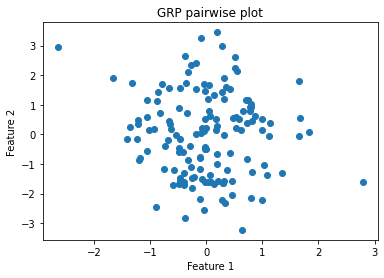

In [45]:
plt.scatter(X_trans_grp[:,0], X_trans_grp[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('GRP pairwise plot')
plt.show()

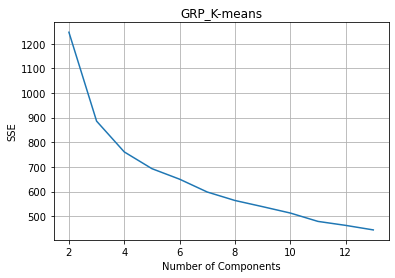

In [46]:
# GRP and k-means
k_means_tuning('GRP_K-means', X_trans_grp, n_components)

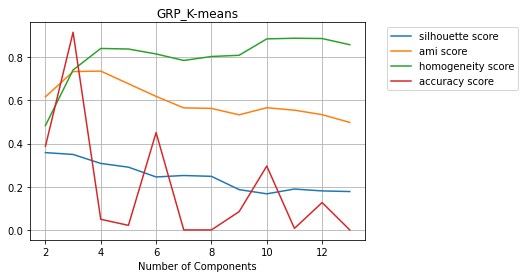

In [47]:
k_means_scoring('GRP_K-means', X_trans_grp, y_train, n_components)

In [48]:
# choose number of clusters that has the highest sc 
y_pred_grp = run_kmeans(X_trans_grp, 3)

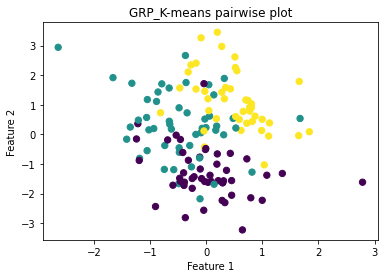

In [49]:
k_means_pairwise_plot('GRP_K-means pairwise plot', X_trans_grp, y_pred_grp)

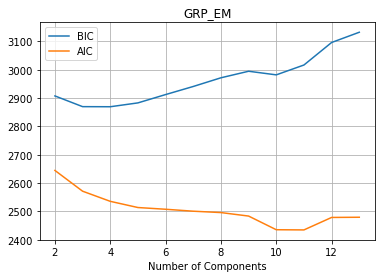

In [50]:
# GRP and EM
em_tuning('GRP_EM', X_trans_grp, n_components)

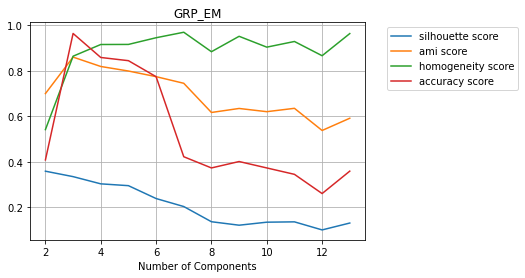

In [51]:
em_scoring('GRP_EM', X_trans_grp, y_train, n_components)

In [52]:
gmm_labels_grp = run_em(X_trans_grp, 3)

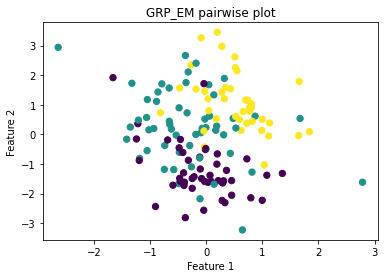

In [53]:
em_pairwise_plot('GRP_EM pairwise plot', X_trans_grp, gmm_labels_grp)

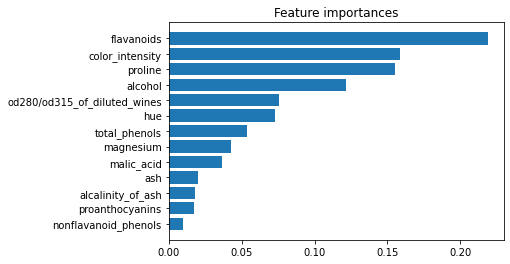

In [54]:
# Random forest--feature selection
rf = RF(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
features = raw_data.feature_names
feature_imp = rf.feature_importances_
f_i = list(zip(features, feature_imp))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.title('Feature importances')
plt.show()

In [55]:
# feature selection (drop features importance less than 0.05)
feature_df = pd.DataFrame(feature_imp, columns=['feature importance'], index=raw_data.feature_names)
top_feature_df = feature_df[feature_df['feature importance'] >= 0.05]
index = top_feature_df.index.tolist()
rfc_X_train_ = pd.DataFrame(X_train, columns=raw_data.feature_names)
rfc_X_test = pd.DataFrame(X_test, columns=raw_data.feature_names)
rfc_df = rfc_X_train_[index]
rfc_test_df = rfc_X_test[index]
rfc_train = np.array(rfc_df)
rfc_test = np.array(rfc_test_df)

In [56]:
rfc_df.shape

(142, 7)

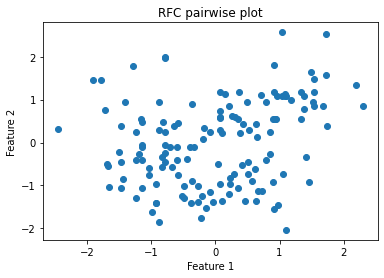

In [57]:
# pairwise plot two features
plt.scatter(rfc_train[:,0], rfc_train[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('RFC pairwise plot')
plt.show()

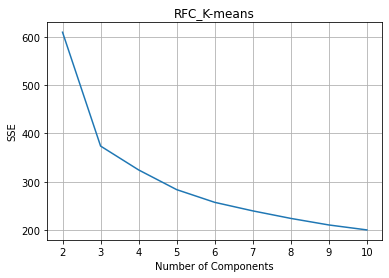

In [58]:
# RFC and kmeans
rfc_n = range(2, 11)
k_means_tuning('RFC_K-means', rfc_train, rfc_n)

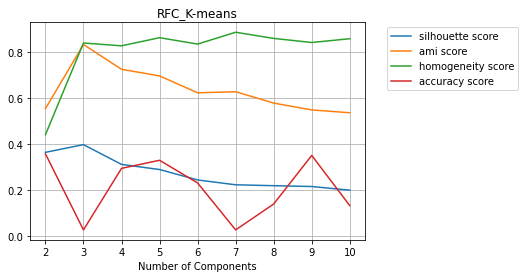

In [59]:
k_means_scoring('RFC_K-means', rfc_train, y_train, rfc_n)

In [60]:
# choose number of clusters that has the highest sc 
y_pred_rfc = run_kmeans(rfc_train, 3)

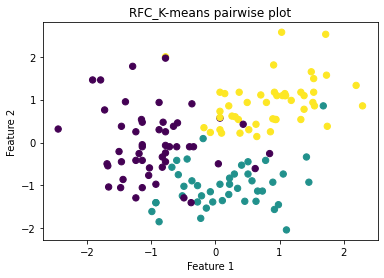

In [61]:
k_means_pairwise_plot('RFC_K-means pairwise plot', rfc_train, y_pred_rfc)

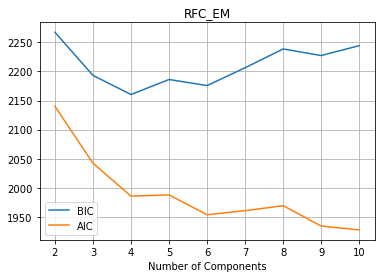

In [62]:
# RFC and EM
em_tuning('RFC_EM', rfc_train, rfc_n)

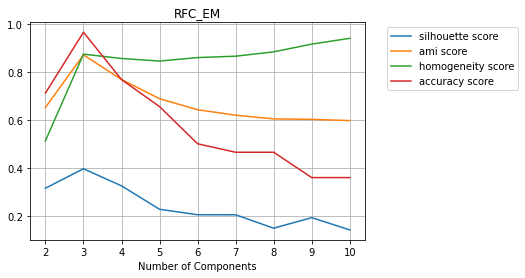

In [63]:
em_scoring('RFC_EM', rfc_train, y_train, rfc_n)

In [64]:
gmm_labels_rfc = run_em(rfc_train, 3)

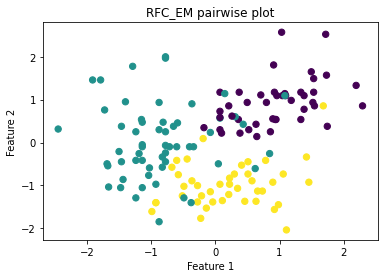

In [65]:
em_pairwise_plot('RFC_EM pairwise plot', rfc_train, gmm_labels_rfc)

### neural network 

In [66]:
# funtion to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=(0.6,1), cv=5, n_jobs=1, train_sizes=np.linspace(0.1,1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    return plt

In [67]:
# plot loss curve for neural network
def plot_loss_curve(estimator, title, X, y):
    estimator.fit(X, y)
    plt.figure()
    plt.plot(estimator.loss_curve_)
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [68]:
# Neural network: hidden layers
clf_nn = MLPClassifier(max_iter=10000, warm_start=True, random_state=1)
def nodes_tune(title, clf_nn, X, y):
    param_range = np.linspace(1,50,25).astype('int')
    train_scores, test_scores = validation_curve(clf_nn, X_trans_pca, y_train, param_range=param_range, param_name='hidden_layer_sizes', cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(param_range, train_scores_mean, label='Train Score')
    plt.plot(param_range, test_scores_mean, label='Cross validation Score')
    plt.legend()
    plt.title(title)
    plt.xlabel("Number of Nodes")
    plt.ylabel("Score")
    plt.grid()
    plt.show()

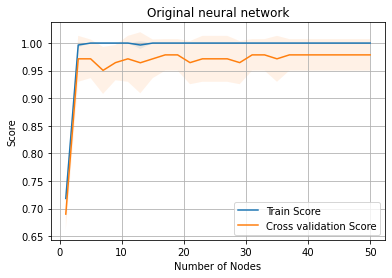

In [69]:
# neural network
nodes_tune('Original neural network', clf_nn, X_train, y_train)

In [70]:
# Neural network: Learning rate
def lr_tune(title, clf_nn, X, y):
    param_range = np.logspace(-4, 0, 10)
    train_scores, test_scores = validation_curve(clf_nn, X, y, param_range=param_range, param_name='learning_rate_init', cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.semilogx(param_range, train_scores_mean, label='Train Score')
    plt.semilogx(param_range, test_scores_mean, label='Cross validation Score')
    plt.legend()
    plt.title(title)
    plt.xlabel("Learning rate")
    plt.ylabel("Score")
    plt.grid()
    plt.show()

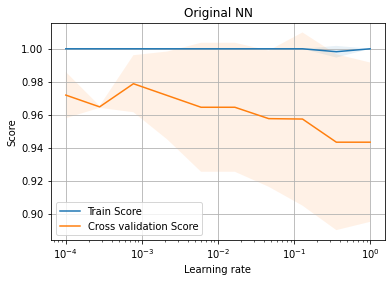

In [71]:
# neural network learing rate tune
lr_tune('Original NN', clf_nn, X_train, y_train)

### GridSearchCV parameters tuning

In [72]:
params = {
        'hidden_layer_sizes': [5, 15, 40],
#         'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'learning_rate_init': [0.0005, 0.001, 0.01, 0.05, 0.1, 0.5],
        'max_iter': [10000],
        'warm_start': [True],
        'random_state': [1]
        }

In [73]:
# function to train the models and predict on the test data
def classify(classifier, X_train, Y_train, X_test, Y_test, title):
    train_start = time.time()
    grid = GridSearchCV(classifier, 
                    params,
                    refit=True,
                    cv = 5, 
                    scoring = 'accuracy', # scoring metric
                    n_jobs = -1
                   )
    estimator = grid.fit(X_train, Y_train)
    train_end = time.time()
    train_diff = train_end - train_start

    train_score = estimator.score(X_train, Y_train)
    test_score = estimator.score(X_test, Y_test)
    print("trained in {f:.6f} s ".format(f=train_diff) + "with train score " + "{tr:.4f}".format(tr=train_score) + " and test score " + "{te:.2f}".format(te=test_score))
    
    plot_learning_curve(estimator, title, X_train, Y_train)
    
    test_start = time.time()
    predictions = estimator.predict(X_test)
    test_end = time.time()
    test_diff = test_end - test_start

    print(classification_report(Y_test, predictions))
    
    print(title, grid.best_params_)
    return train_score,  test_score, train_diff, test_diff

trained in 5.018512 s with train score 1.0000 and test score 1.00


C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Ana

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

original NN {'hidden_layer_sizes': 5, 'learning_rate_init': 0.1, 'max_iter': 10000, 'random_state': 1, 'warm_start': True}


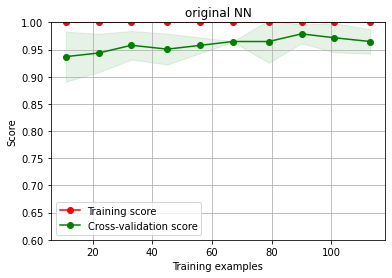

In [74]:
# original NN
nn_train_scores, nn_test_scores, nn_train_time, nn_test_time = classify(clf_nn, X_train, y_train, X_test, y_test, 'original NN')

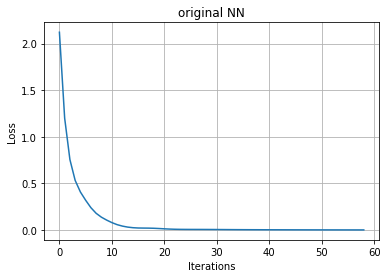

In [75]:
nn_original = MLPClassifier(hidden_layer_sizes=(5),  learning_rate_init=0.1, max_iter=10000, warm_start=True, random_state=1)
plot_loss_curve(nn_original, 'original NN', X_train, y_train)

trained in 1.848103 s with train score 1.0000 and test score 0.33


C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Ana

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.86      0.92      0.89        13
           2       0.00      0.00      0.00         9

    accuracy                           0.33        36
   macro avg       0.29      0.31      0.30        36
weighted avg       0.31      0.33      0.32        36

PCA_NN {'hidden_layer_sizes': 5, 'learning_rate_init': 0.01, 'max_iter': 10000, 'random_state': 1, 'warm_start': True}


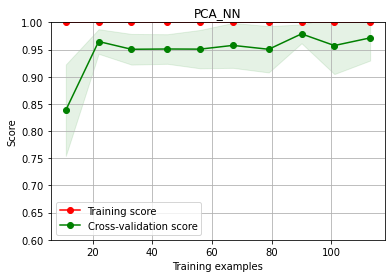

In [76]:
# PCA 
pca_train_scores, pca_test_scores, pca_train_time, pca_test_time = classify(clf_nn, X_trans_pca, y_train, X_test_pca, y_test, 'PCA_NN')

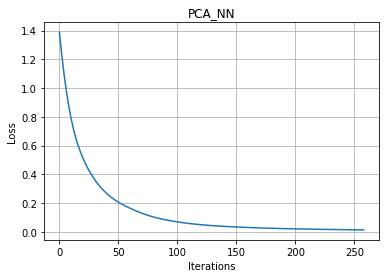

In [77]:
pca_nn = MLPClassifier(hidden_layer_sizes=(5),  learning_rate_init=0.01, max_iter=10000, warm_start=True, random_state=1)
plot_loss_curve(pca_nn, 'PCA_NN', X_trans_pca, y_train)

trained in 4.119961 s with train score 0.9930 and test score 0.36


C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Ana

              precision    recall  f1-score   support

           0       0.36      0.29      0.32        14
           1       0.40      0.46      0.43        13
           2       0.30      0.33      0.32         9

    accuracy                           0.36        36
   macro avg       0.35      0.36      0.35        36
weighted avg       0.36      0.36      0.36        36

ICA_NN {'hidden_layer_sizes': 5, 'learning_rate_init': 0.001, 'max_iter': 10000, 'random_state': 1, 'warm_start': True}


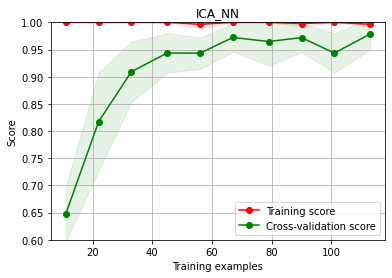

In [78]:
# ICA
ica_train_scores, ica_test_scores, ica_train_time, ica_test_time = classify(clf_nn, X_trans_ica, y_train, X_test_ica, y_test, 'ICA_NN')

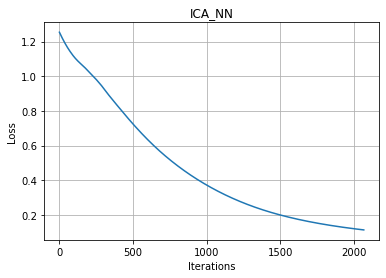

In [79]:
ica_nn = MLPClassifier(hidden_layer_sizes=(5),  learning_rate_init=0.001, max_iter=10000, warm_start=True, random_state=1)
plot_loss_curve(ica_nn, 'ICA_NN', X_trans_ica, y_train)

trained in 1.938822 s with train score 0.9859 and test score 0.92


C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Ana

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.92      0.85      0.88        13
           2       0.89      0.89      0.89         9

    accuracy                           0.92        36
   macro avg       0.91      0.91      0.91        36
weighted avg       0.92      0.92      0.92        36

GRP_NN {'hidden_layer_sizes': 15, 'learning_rate_init': 0.0005, 'max_iter': 10000, 'random_state': 1, 'warm_start': True}


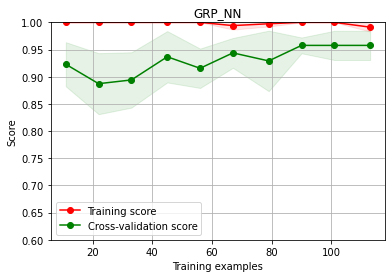

In [80]:
# GRP
grp_train_scores, grp_test_scores, grp_train_time, grp_test_time = classify(clf_nn, X_trans_grp, y_train, X_test_grp, y_test, 'GRP_NN')

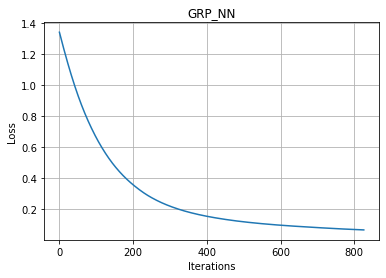

In [81]:
grp_nn = MLPClassifier(hidden_layer_sizes=(15),  learning_rate_init=0.0005, max_iter=10000, warm_start=True, random_state=1)
plot_loss_curve(grp_nn, 'GRP_NN', X_trans_grp, y_train)

trained in 2.515258 s with train score 1.0000 and test score 0.97


C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Ana

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00         9

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.98        36
weighted avg       0.97      0.97      0.97        36

RFC_NN {'hidden_layer_sizes': 15, 'learning_rate_init': 0.01, 'max_iter': 10000, 'random_state': 1, 'warm_start': True}


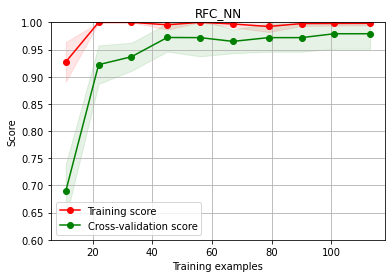

In [82]:
# RFC
rfc_train_scores, rfc_test_scores, rfc_train_time, rfc_test_time = classify(clf_nn, rfc_df, y_train, rfc_test_df, y_test, 'RFC_NN')

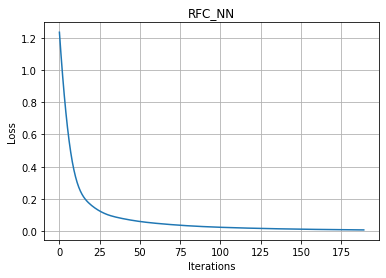

In [83]:
rfc_nn = MLPClassifier(hidden_layer_sizes=(15),  learning_rate_init=0.01, max_iter=10000, warm_start=True, random_state=1)
plot_loss_curve(rfc_nn, 'RFC_NN', rfc_df, y_train)

### clustering with neural network

In [84]:
# K-means and neural network
k_means = KMeans(n_clusters=3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42) 
k_means.fit(X_train)
k_means_train = k_means.transform(X_train)
k_means_test =  k_means.transform(X_test)

trained in 2.760617 s with train score 0.9859 and test score 0.97


C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Ana

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.93      1.00      0.96        13
           2       1.00      0.89      0.94         9

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36

K-Means NN {'hidden_layer_sizes': 15, 'learning_rate_init': 0.0005, 'max_iter': 10000, 'random_state': 1, 'warm_start': True}


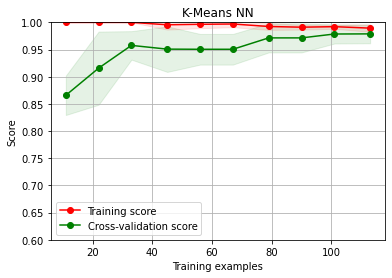

In [85]:
# K-means NN
nn_km_train_scores, nn_km_test_scores, nn_km_train_time, nn_km_test_time = classify(clf_nn, k_means_train, y_train, k_means_test, y_test, 'K-Means NN')

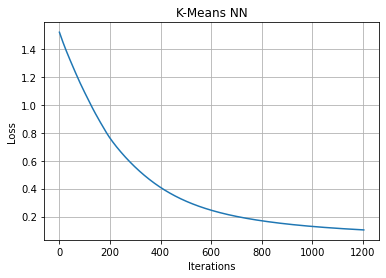

In [86]:
km_nn = MLPClassifier(hidden_layer_sizes=(15),  learning_rate_init=0.0005, max_iter=10000, warm_start=True, random_state=1)
plot_loss_curve(km_nn, 'K-Means NN', k_means_train, y_train)

In [87]:
# EM and neural network
gmm = GaussianMixture(n_components = 3, covariance_type='tied', warm_start = True, random_state=42)
gmm.fit(X_train)
gmm_train = gmm.predict_proba(X_train)
gmm_test = gmm.predict_proba(X_test)

trained in 2.556171 s with train score 0.9789 and test score 0.97


C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ywang64\Ana

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00         9

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.98        36
weighted avg       0.97      0.97      0.97        36

EM_NN {'hidden_layer_sizes': 5, 'learning_rate_init': 0.0005, 'max_iter': 10000, 'random_state': 1, 'warm_start': True}


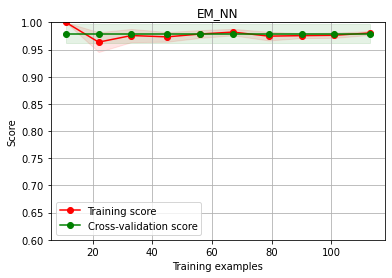

In [88]:
# EM_NN
nn_em_train_scores, nn_em_test_scores, nn_em_train_time, nn_em_test_time = classify(clf_nn, gmm_train, y_train, gmm_test, y_test, 'EM_NN')

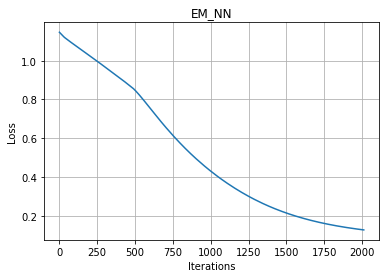

In [89]:
em_nn = MLPClassifier(hidden_layer_sizes=(5),  learning_rate_init=0.0005, max_iter=10000, warm_start=True, random_state=1)
plot_loss_curve(em_nn, 'EM_NN', gmm_train, y_train)

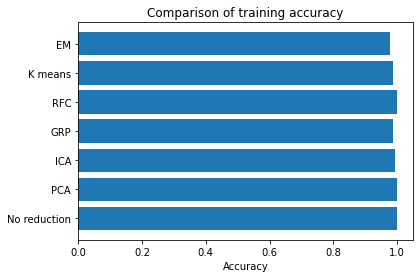

In [95]:
# plot models train scores
classifiers = ('No reduction', 'PCA', 'ICA', 'GRP', 'RFC', 'K means', 'EM')
train_scores = [nn_train_scores, pca_train_scores, ica_train_scores, grp_train_scores, rfc_train_scores, nn_km_train_scores, nn_em_train_scores]
scores = np.array(train_scores)
y_pos = np.arange(len(classifiers))
plt.figure()
plt.barh(y_pos, scores)
plt.gca().set_yticks(y_pos)
# plt.gca().set_xlim(0.8, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of training accuracy')
plt.xlabel('Accuracy')
plt.show()

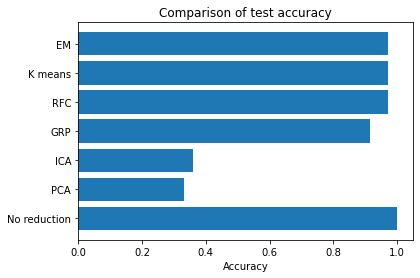

In [96]:
# plot models test scores
classifiers = ('No reduction', 'PCA', 'ICA', 'GRP', 'RFC', 'K means', 'EM')
test_scores = [nn_test_scores, pca_test_scores, ica_test_scores, grp_test_scores, rfc_test_scores, nn_km_test_scores, nn_em_test_scores]
scores = np.array(test_scores)
y_pos = np.arange(len(classifiers))
plt.figure()
plt.barh(y_pos, scores)
plt.gca().set_yticks(y_pos)
# plt.gca().set_xlim(0.8, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of test accuracy')
plt.xlabel('Accuracy')
plt.show()

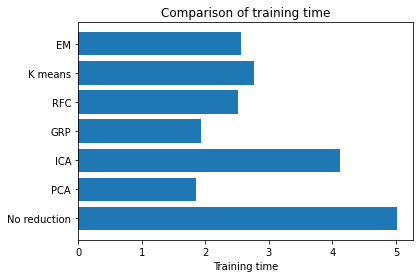

In [97]:
# plot models training time
classifiers = ('No reduction', 'PCA', 'ICA', 'GRP', 'RFC', 'K means', 'EM')
train_time = [nn_train_time, pca_train_time, ica_train_time, grp_train_time, rfc_train_time, nn_km_train_time, nn_em_train_time]
train_time_np = np.array(train_time)
y_pos = np.arange(len(classifiers))
plt.figure()
plt.barh(y_pos, train_time_np)
plt.gca().set_yticks(y_pos)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of training time')
plt.xlabel('Training time')
plt.show()